In [35]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

rmse = lambda y, y_pred: mse(y, y_pred, squared=False)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


#### Set up dataset

In [36]:
frac_train, frac_val, frac_test = 0.6, 0.2, 0.2
assert frac_train + frac_val + frac_test == 1.0


x, y = load_diabetes(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=frac_test,
    random_state=0,
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=frac_val / (frac_train + frac_val),
    random_state=0,
)

x_train = StandardScaler().fit_transform(x_train)
x_val = StandardScaler().fit_transform(x_val)
x_test = StandardScaler().fit_transform(x_test)


#### find the pareto frontier for the given alpha range

In [37]:
def score(model, x_train, y_train, x_val, y_val, x_test, y_test, eps=1e-6):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train)

    dummy_y_train = dummy.predict(x_train)
    dummy_y_val = dummy.predict(x_val)
    dummy_y_test = dummy.predict(x_test)

    model_y_train = model.predict(x_train)
    model_y_val = model.predict(x_val)
    model_y_test = model.predict(x_test)

    n_selected = np.sum(np.abs(model.coef_) > eps)

    return {
        "train": rmse(y_train, model_y_train) / rmse(y_train, dummy_y_train),
        "val": rmse(y_val, model_y_val) / rmse(y_val, dummy_y_val),
        "test": rmse(y_test, model_y_test) / rmse(y_test, dummy_y_test),
        "density": n_selected / len(model.coef_),
    }


In [38]:
res = []
alphas = np.logspace(-4, 2, 100)

for alpha in tqdm(alphas):
    lasso = Lasso(alpha=alpha, random_state=0)
    lasso.fit(x_train, y_train)

    res.append(score(lasso, x_train, y_train, x_val, y_val, x_test, y_test))


100%|██████████| 100/100 [00:00<00:00, 663.70it/s]


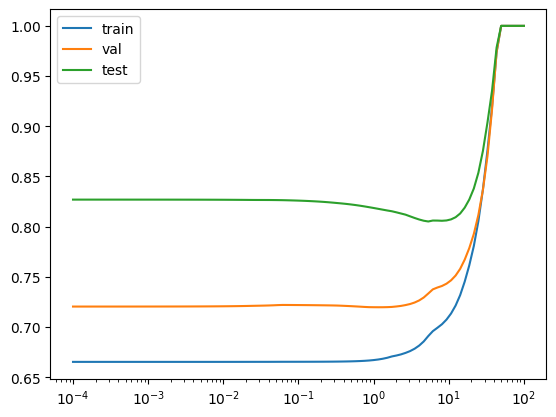

In [39]:
plt.plot(alphas, [r["train"] for r in res], label="train")
plt.plot(alphas, [r["val"] for r in res], label="val")
plt.plot(alphas, [r["test"] for r in res], label="test")

plt.xscale("log")

plt.legend()

plt.show()


In [40]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]


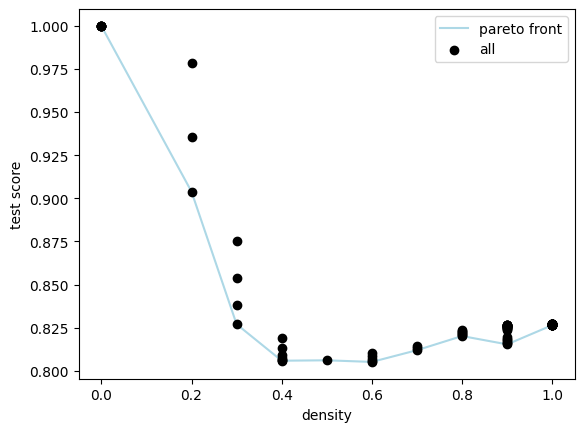

In [41]:
densities = np.array([r["density"] for r in res])
scores = np.array([r["test"] for r in res])

pareto_density, pareto_score = pareto_front(scores, densities)
plt.plot(
    pareto_density, pareto_score, label="pareto front", color="lightblue", zorder=0
)

plt.scatter(densities, scores, label="all", color="k", zorder=1)

plt.xlabel("density")
plt.ylabel("test score")

plt.legend()

plt.show()


#### Try with Ax and targeting specific density/performance tradeoffs

In [42]:
from ax.service.ax_client import AxClient, ObjectiveProperties

import warnings
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)


# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)


In [43]:
def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
):
    model = ModelClass(**params)
    model.fit(x_train, y_train.flatten())

    return {
        "train_error": float(rmse(y_train.flatten(), model.predict(x_train))),
        "val_error": float(rmse(y_val.flatten(), model.predict(x_val))),
        "test_error": float(rmse(y_test.flatten(), model.predict(x_test))),
        "model": model,
    }


def train_lasso(params, x_train, y_train, x_val, y_val, x_test, y_test):
    res = train_sklearn(
        Lasso,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    eps = 1e-6

    return {
        "density": np.sum(np.abs(res["model"].coef_) > eps) / len(res["model"].coef_),
        **res,
    }


def train_elastic_net(params, x_train, y_train, x_val, y_val, x_test, y_test):
    # thanks to sklearn
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
    new_params = params.copy()
    alpha = new_params.pop("alpha")
    lam = new_params.pop("lambda")
    new_params["alpha"] = alpha + lam
    new_params["l1_ratio"] = alpha / (alpha + lam)

    res = train_sklearn(
        ElasticNet,
        new_params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    eps = 1e-6

    return {
        "density": np.mean(np.abs(res["model"].coef_) > eps),
        **res,
    }


def dummy_regressor(x_train, y_train, x_val, y_val, x_test, y_test):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train.flatten())

    return {
        "train_error": float(rmse(y_train.flatten(), dummy.predict(x_train))),
        "val_error": float(rmse(y_val.flatten(), dummy.predict(x_val))),
        "test_error": float(rmse(y_test.flatten(), dummy.predict(x_test))),
    }


In [44]:
def score(dummy_res, model_res, alpha):
    res = {
        "error": {
            "train": model_res["train_error"] / dummy_res["train_error"],
            "val": model_res["val_error"] / dummy_res["val_error"],
            "test": model_res["test_error"] / dummy_res["test_error"],
        },
        "density": model_res["density"],
    }

    res["pareto"] = {
        "train": alpha * res["density"] + (1 - alpha) * res["error"]["train"],
        "val": alpha * res["density"] + (1 - alpha) * res["error"]["val"],
        "test": alpha * res["density"] + (1 - alpha) * res["error"]["test"],
    }

    return res


In [45]:
train_fn = {
    Lasso.__name__: train_lasso,
    ElasticNet.__name__: train_elastic_net,
}


def optimize_model(params, model_name, n_trials, minimize, loss_type, alpha):
    dummy_res = dummy_regressor(
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    ax_client = AxClient(
        random_seed=0,
        verbose_logging=False,
    )

    ax_client.create_experiment(
        name=model_name,
        parameters=params,
        objectives={loss_type: ObjectiveProperties(minimize=minimize)},
        overwrite_existing_experiment=True,
    )

    for _ in range(n_trials):
        round_params, trial_index = ax_client.get_next_trial()

        try:
            model_res = train_fn[model_name](
                round_params,
                x_train=x_train,
                y_train=y_train,
                x_val=x_val,
                y_val=y_val,
                x_test=x_test,
                y_test=y_test,
            )
            model_score = score(dummy_res, model_res, alpha)
            ax_client.complete_trial(
                trial_index=trial_index, raw_data=model_score["pareto"]["val"]
            )
        except ValueError as e:
            print(e)
            ax_client.abandon_trial(
                trial_index=trial_index,
                reason=str(e),
            )

    best_parameters, _ = ax_client.get_best_parameters()

    model_res = train_fn[model_name](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )
    model_score = score(dummy_res, model_res, alpha)

    metadata = {
        "model": {
            "name": model_name,
            "results": model_res,
            "score": model_score,
        },
        "dummy": {
            "name": "DummyRegressor",
            **dummy_res,
        },
    }

    return metadata


In [46]:
lasso_params = [
    {
        "name": "alpha",
        "type": "range",
        "bounds": [1e-4, 1e2],
        "log_scale": True,
    }
]

elastic_params = [
    {
        "name": "alpha",
        "type": "range",
        "bounds": [1e-4, 1e2],
        "log_scale": True,
    },
    {
        "name": "lambda",
        "type": "range",
        "bounds": [1e-4, 1e2],
        "log_scale": True,
    },
]


In [47]:
alphas = np.linspace(0, 1, 101, endpoint=True)
lasso_results = []
n_iters = 10

for alpha in tqdm(alphas):
    lasso_results.append(
        optimize_model(lasso_params, Lasso.__name__, n_iters, True, "rmse", alpha)
    )

elastic_results = []

for alpha in tqdm(alphas):
    elastic_results.append(
        optimize_model(
            elastic_params, ElasticNet.__name__, n_iters, True, "rmse", alpha
        )
    )


 27%|██▋       | 27/101 [00:37<01:42,  1.39s/it]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
 29%|██▊       | 29/101 [00:40<01:42,  1.43s/it]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
 30%|██▉       | 30/101 [00:42<01:38,  1.38s/it]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
 31%|███       | 31/

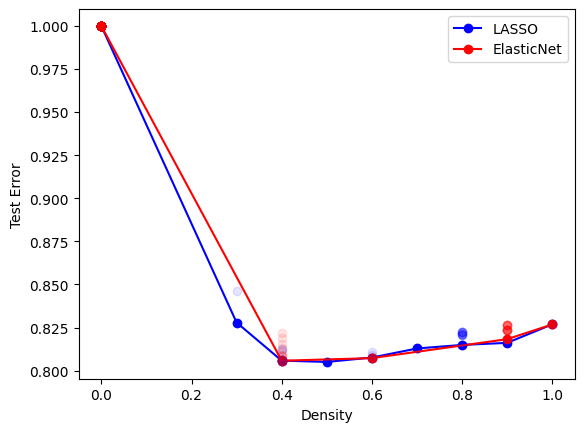

In [49]:
density = np.array([e["model"]["score"]["density"] for e in lasso_results])
test_error = np.array([e["model"]["score"]["error"]["test"] for e in lasso_results])

pareto_density, pareto_test_error = pareto_front(test_error, density)

plt.plot(
    pareto_density,
    pareto_test_error,
    color="blue",
    label="LASSO",
    zorder=0,
    marker="o",
)

plt.scatter(density, test_error, color="blue", zorder=1, alpha=0.1)

density = np.array([e["model"]["score"]["density"] for e in elastic_results])
test_error = np.array([e["model"]["score"]["error"]["test"] for e in elastic_results])

pareto_density, pareto_test_error = pareto_front(test_error, density)

plt.plot(
    pareto_density,
    pareto_test_error,
    color="red",
    label="ElasticNet",
    zorder=0,
    marker="o",
)

plt.scatter(density, test_error, color="red", zorder=1, alpha=0.1)

plt.xlabel("Density")
plt.ylabel("Test Error")

plt.legend()

plt.show()


In [54]:
from sklearn.metrics import auc

print("Area under pareto front (lower is better)")

density = np.array([e["model"]["score"]["density"] for e in lasso_results])
test_error = np.array([e["model"]["score"]["error"]["test"] for e in lasso_results])

pareto_density, pareto_test_error = pareto_front(test_error, density)
print(f"\tLASSO:      {auc(pareto_density, pareto_test_error):.4}")

density = np.array([e["model"]["score"]["density"] for e in elastic_results])
test_error = np.array([e["model"]["score"]["error"]["test"] for e in elastic_results])

pareto_density, pareto_test_error = pareto_front(test_error, density)
print(f"\tElasticNet: {auc(pareto_density, pareto_test_error):.4}")


Area under pareto front (lower is better)
	LASSO:      0.8432
	ElasticNet: 0.8486
